# ASTR 425 Project - Gravitational Lensing
16 Dec. 2020 <br>
Lars Borchert <br>
1835054

## Introduction

![fig0](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_10-49-37.png?raw=true)

I have split this into three sections.
The first is just the three plots required for the project prompt.
In the second section, I will be talking about how the 
program works, showing some of my favorite lensed images, and discussing the 
limitations and artifacting. In the third section, I will include all the code 
being used in the latest version so you can play with the lens yourself if you want.

## Section 0 - The required plots

#### Configuration 1: Source almost directly behind the lens

Lens at x = 2 arcseconds, just barely off center:
![conf1-1](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-16_11-49-54.png?raw=true)

Lens and source centered:
![conf1-2](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-16_11-04-43.png?raw=true)

#### Configuration 2: Source just inside the Einstein Radius

![conf2](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-16_10-44-53.png?raw=true)

#### Configuration 3: Source is just outside the Einstein Radius

![conf3](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-16_10-55-31.png?raw=true)

#### Configuration 4: Hubble image of SPT0615

![conf4](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-16_10-31-04.png?raw=true)

## Section I - How it works

I implemented two different methods for the lensing, method 1 and method 2. 
Both methods work by recieving some source image as an input, then mapping 
values from pixels in the source image to the correct location on the
lensed image, which I will refer to more often as the observed image.

Method 1 loops through the pixels in the source image. With respect to the lens 
location, we know a value for beta, the angle from the observer to a position
on the source plane.
If we say that our x and y coordinates are in angles, in this case arcseconds, we can easily calculate beta just by using the Pythagorean theorem.
We then use this beta and the properties of the 
gravitational body to find theta, the angle from the observer to a position 
on the image plane. The equation for this is given on slide 17 of lecture 9:

$$
\theta_{1,2} = \frac{1}{2} \left( \beta \pm \left( \beta^{2} + 4\theta^{2}_{E} \right)^{\frac{1}{2}} \right)
$$

where

$$
\theta_{E} = \left( \frac{4 G M}{c^{2}} \frac{D_{ds}}{D_{d}D_{s}}\right)^{\frac{1}{2}}
$$

where $M$ is the mass of the lens, $D_{ds}$ is the distance between the source and the lens, $D_{d}$ is the distance between the observer and the lens, and $D_{s}$ is the distance between the observer and the source.

To keep things easy for myself, for the entirety of this project I used the example values provided on slide 12 of lecture 9:

$$
M = 10^{13} M_{0}
$$
$$
D_{ds} = 1.41 Gpc
$$
$$
D_{d} = 1.4 Gpc
$$
$$
D_{s} = 1.73 Gpc
$$

These result in an Einstein radius of 6.9 arcseconds. In the lens program, the Einstein radius can be verified by calling the einstein_radius attribute. These values can also be changed when constructing the lens object, and a new Einstein radius attribute is calculated accordingly.

An important note here is that our equation for theta gives two values with a given beta. These are each handled seperately. When we know theta, we can use the angle of our position vector to convert theta into a new position vector in the cartesian system, and then convert that vector into indices in the numpy array for the observed image. We then add the flux from the current source pixel to the just calculated observed image pixel.

We also need to have a magnification factor for the flux added to each pixel. Without magnification corrections, the image inside the Einstein ring would be far too bright, and the outer one too dim. Magnification factor $\mu$ (called "mag" in the code), is implemented as on slide 22 of lecture 9:

$$
\mu_{1,2} = \frac{u^{2} + 2}{2 u \left(u^{2} + 4 \right)^{\frac{1}{2}}} \pm \frac{1}{2}
$$

where

$$
u = \frac{\beta}{\theta_{E}}
$$

This correction is easily applied, just by scaling the value added to a particular pixel by the appropriate $\mu$.

Method 1 was implemented first because it is the more
"forward" method. Light begins at the source plane, then reaches the lens, 
and is mapped to the observed plane.

This method can also be fast, as we can 
impose a check before doing any calculations for a pixel, to see if the pixel 
is empty or not. An empty pixel, not emitting any light, does not need to be
lensed. As long as our source image is largely empty space, method one can be
very fast on large images, despite still looping over every pixel.

The main issue with this method is artifacting due to rounding. In order to
display an image, that image needs to be in a grid, with a fixed width and height.
But our calculations for theta do not give values that always map perfectly to
centers of pixels. Rounding effects can cause us to not only have a slightly
inaccurate image, they can be systematic, and lead to clearly defined structures
of pixels that do not get filled at all. An example is shown in the image below:

##### Figure 1

![fig1](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-11-30_16-44-55.png?raw=true)

On the left, we have an image of the galaxy UGCA 193 taken by the Hubble Telescope,
without color. On the right, we have the result of lensing from a lens located at
(5, 10) arcseconds. We can easily see the flower petal like structures in the lensed
image. Looking closely, we can see that the structures seem to bulge outwards at horizontal and vertical, and inwards on the diagonals. This suggests the artificating does have to do with the grid structure of the image. When thinking about a grid of pixels, this diagram is useful:

##### Figure 2

![fig2](https://github.com/Lars314/astro425-final-project/blob/master/fig1.png?raw=true)

Pixels are arranged in a grid, with their numerical locations in the red dots.
The radial distance to horizontal and vertical pixels is shorter than to diagonal pixels. Our rounding will remove more position information from diagonal pixels than directly alligned ones, which results in artifacting that is not circularly symmetric.

Additionally, we can see that some pixels are not being filled at all. If only one pixel from the source image is going to map to a pixel on the observed image, and on one side of the pixel we have a theta too low to reach the observed pixel, and on the other side we have a theta too high, then that pixel will not be mapped at all. We can see that these structures also appear as well defined 'ripples' in our image.

One way to combat both of these is to just increase the number of pixels in the image. The following is the same image, but while the first one was 100x100 pixels, this one is 200x200:

##### Figure 3

![fig3](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_12-39-14.png?raw=true)

This improves things somewhat, but it is not a very desireable solution. The artifacts are smaller but still fairly dense. And because we loop through every pixel in and calculate a theta for each, the time it takes to run the program goes as the image area. Doubling the width and height of the image quadruples the time it takes to process the image.
With only a minor improvement in our artifacting, we would need to operate at very high resolution in order to see any major benefits, which could take hours to process.

There is another clearly visible artifact here, the presence of discrete bright areas on the Einstein ring, but this will be discussed in more detail later on.

The solution to the rounding problem in method 1 was to move away from looping through the source image, and instead loop through the observed image.
By doing this, we can ensure that every pixel we see actually recieves a value.

The mathematics of method 2 is very similar to method 1, but inversed.
Because we are going through the array of the observed image pixels, we start with theta instead of beta. This is now easily calculated from the x and y location of a pixel on the image, with the Pythagorian theorem, as our x and y are already in units of arcseconds. We can then take the our theta and find a beta, by inversing the equation we had already worked with to:

$$
\beta = \theta^{2} - \frac{\theta_{E}^{2}}{\theta}
$$

From here, we use beta to calculate a location on the source image to fill into this pixel on the observed image.
An advantage of this method from a understandability standpoint is that we no longer need to deal with the positive and negative solutions given when calculating theta in terms of beta. We are looping through every theta value anyway, and so the calculation for one pixel only needs to be done once, not twice.

The only time that this causes problems is in the calculation of magnification. The positive and negative theta solutions are magnified differently, adding or subtracting 0.5 respectively. We can get around this by knowing that the negative solution will be be where the value of theta is less than beta, and the positive solution is where theta is greater than beta. We perform this check, then calculate and apply magnification in the same way as before.

The result of using this method on the same test scenario as in the figure 1 is shown here:

##### Figure 4:

![fig4](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_13-16-02.png?raw=true)

The result is not perfect, but a major improvement. The artifacting due to missing pixels is gone. We still get some 'stretch' like effects due to rounding, but these are essentially invisible in higher resolution images. The most notable issue here is with the Einstein radius. We can see that it does not allign nicely with the lens location crosshair. The issue here is due to binning. The crosshair is being plotted in matplotlib on top of what is essentially a histogram of brightness values. The crosshair can be plotted anywhere (within the limits of the resolution of the matplotlib figure, but this is much higher than the source and observed images). But the image itself has much coarser binning. Furthermore, the numpy array coordinate system has its origin at the top left of the image, and pixel locations are not centered. This is clearer if we decrease the resolution:

##### Figure 5:

![fig5](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_13-23-37.png?raw=true)

If we just focus our attention on the object in the lower left corner, at an x angle of -20 arcseconds, we can see that an integer value of arcseconds is in the corner of a pixel, not the center.
This along with the numpy origin being in the top left is responsible for the shifting of the Einstein ring crosshair on the image.
This could be corrected by adjusting the location by half a pixel size, but this is not implemented as the effect is only really visible for low resolution images.

Now we can turn our attention to an artifacting issue that has been present in both methods, and in all of these images: some locations on the Einstein ring are very bright. These locations are also symmetric about the ring. If we look back at figures 1 and 3, we see clearly defined bright spots, at 45 degree angles around the lens. If we look at figures 4 and 5, we see bright spots at 30 and 45 degree angles, but oddly not at 90. This strangeness is artificial, and will be explained soon.

Going back to figure 2, we know that the horizontal and vertical pixels are closer to the center pixel radially than the diagonal ones. This is very important to our magnificaion equation:

$$
\mu_{1,2} = \frac{u^{2} + 2}{2 u \left(u^{2} + 4 \right)^{\frac{1}{2}}} \pm \frac{1}{2}
$$

Taking the derivative of this gives us:

$$
\frac{\,d\mu}{\,du} = 2\frac{u^{2}\left(u^{2}+2\right)^{\frac{1}{2}} - \left(u^{2}+2\right)^{\frac{3}{2}}}{4u^{4} + 8u^{2}}
$$

At small values of u, which correspond to small values of beta, magnification blows up. From our calculations in method 1:

$$
\theta_{1,2} = \frac{1}{2} \left( \beta \pm \left( \beta^{2} + 4\theta^{2}_{E} \right)^{\frac{1}{2}} \right)
$$

We know that at very small $\beta$, theta becomes the Einstein Radius. Combining all these things, we see that those pixels that are the brightest in figure 3 are the four pixels on the Einstein ring that would map radially closest to being directly behind the lens on the source image. We ignore beta=0 to avoid overflow errors in python, but we still need to account for artifacting introduced by the grid.

Figures 4 and 5 have similar artifacting as figure 3, but at different locations. But the magnification calculations are no different, so what is going on here?

I referred to this as an artificial problem because the version of the lens program used in rendering figures 4 and 5 has the key difference that it is not just ignoring the pixel directly behind the lens, but those 4 imediately adjacent to this pixel as well. This was done by accident when gathering images to include here, but provides an example of one solution to the problem. Just ignoring the highest magnification pixels is one way to spread the effect out. We can also notice that the color mapping matplotlib is using is different between the sets of figures. The images from method 1, from a version of the lensing program without this fix, appear overall dimmer because matplotlib has to scale the colors linearly over a wider range of values.

A different solution is to plot in log scale. But this is not ideal. It does not remove the effect, just hides it somewhat from view. In figure 9, which is plotted with a log scale, we can still see the effect. Additionally, using log scale sometimes created strange artifacting from matplotlib in areas where the pixel values were zero. An example is shown below:

##### Figure 6:

![fig6](https://github.com/Lars314/astro425-final-project/blob/master/fig6.jpg?raw=true)


Another solution is to selectively ignore pixels that would fall onto the Einstein ring.

We can use our normalized angle, $u = \frac{\beta}{\theta_{E}}$, and impose a restriction that the absolute value of $u$ must be greater than some amount. This parameter is passed to the lens as the min_normalized_angle in the constructor.

Because this effect is generally limited to being one or two pixels wide, just ignoring those pixels on a very high resolution image can go unnoticed. But this is not ideal for lower resolution images. An example is shown below:

##### Figure 7:

![fig7](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-06_16-16-23.png?raw=true)

This image is 200x200 pixels, which already takes some time to make, and not only do we see artifacting from the removed pixels, we still see artifacting from the uneven bright spots. The image looks very artificial.

Another problem with is that we need to dial in the value of our minimum normalized angle for different image sizes to try and limit just the pixels we want, but not so many as to produce a new artifact. It is not ideal.

For greyscale style images like above, where we simply map a single brightness value to some color map in matplotlib (here from purple to yellow), this type of artifacting is a headache. The final version of the lenser can use a combination of the above methods to reduce it, but it is not removed entirely.

A more sophisticated method would be to not map a single source pixel to a single observed pixel, but instead map to a swath of observed pixels based on how close we are to the lens. But this would be computationally intensive and complex to implement.

A much simpler solution is to simply cap how bright a pixel can be. Computer screens only have some maximum brightness anyway. And this brightness cap is an inherent feature of adding color support to the lens, which dramatically improves the quality of images.

To add color, we just change what is stored in a pixel from a single value to an array of three integers between 0 and 255, representing red green and blue combinations. Due to numpy's excellent ndarrays, this was very easy to implement. These arrays can be added elementwise together and scaled with the same syntax as floats or integers. The only change needed in the lens code is a check at the very end of processing, converting all RGB color values into lists of integers instead of floats, and imposing the condition that any values greater than 255 should equal 255. This solves the issue of divergent pixel brightness right away, these pixels just get brought down to the maximum brightness of your computer display. Here is our galaxy UGCA 193 with a lens right at the center of the image, in no-color linear scale (figure 8), no-color log scale (figure 9), and then in color (figure 10). Each has a size of 200x200 pixels.

##### Figure 8:

![fig8](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_14-37-57.png?raw=true)

##### Figure 9:

![fig9](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_14-38-04.png?raw=true)

##### Figure 10:

![fig10](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_14-39-30.png?raw=true)


In the realistic image of UGCA 193, the log scale plot reveals that most of the pixels are not actually completely dark. The final result has at least some brightness everywhere except the center void region (more on that shortly), so pixels that look black on the original image must have some small brightness that is being amplified. This is a scenario where method 2 outshines method 1 again. Method 1's advantage was that when we loop through the source image we can ignore blank pixels, improving speed. But on a realistic image like this, almost no pixels are truly blank. And setting a limit that we ignore very dim pixels, not just blank ones, caused its own aliasing style effect around lensed objects; the stars and galaxies looked like they had sharply pixelated edges. So method 2, going through the observed image array, is better again.

The log scale plot has an example of another artifact. In the center of the lens, there is some blank, void region, with the same flower style shape we saw in the artifacting in method 1. This artifacting shape also comes from the grid nature of the image. Here, we are using method 2, and the theta values on these locations have corresponding beta values that are off the scale of the image. The lens program then assumes that we are dealing with empty space, and these pixels are completely blank. The flower shape comes from the fact that on the diagonals, the square image allows for greater values of beta than on the horizontal and vertical lines. A circular image would have this artifact be circular, as every 'curved pixel' just outside the edges of the image would have the same beta value, and thus same theta values.

We can see this void effect again without the log scale, if we use an image that does not have a black background like the sky.
For this experiment, we can take an image the IKEA stuffed animal "Djungelskog" (which is very popular among the younger siblings of many cosmology students) and run it through the lens:

##### Figure 11:

![fig11](https://github.com/Lars314/astro425-final-project/blob/master/test_results/2020-12-15_10-58-31.png?raw=true)

We are able to see the void in the center clearly. There is also the effect that the Einstein ring has a red-orange glow to it. This is likely due to the magnification brightening the brown into orange before reaching the maximum values, where we get white.

Djungelskog is also a verification that the lens is reflecting properly inside the Einstein ring. Looking closely, we can see that the shape of Djungelskog's head and feet in the reflection is just barely preserved and in the correct locations, although fairly blurry.

For some more fun, we can also use the lens to make animations. These take quite a while to process but below is my favorite, and the primary reason this project was submitted in the afternoon and not the early morning:

![fig12](https://github.com/Lars314/astro425-final-project/blob/master/gif_6.gif?raw=true)

## Section II - The program

I took an interative approach to writing the lens, and ended up with 5 versions of the program in total. 
I also kept the results from testing the lens since version 3. It would make this 
notebook far too long to include all the versions here, so I made a github 
repository: https://github.com/Lars314/astro425-final-project

#### Summary of versions:

##### Version 0:

A version I used to mess around with while writing this notebook up.
A version where if I made a change that broke everything, I would still have version 5 intact. I don't include this version in the progression because it is just for intentionally breaking things to show artifacting.

##### Version 1:

Very basic, only uses method 1. Doesn't really work, and only has the positive solution for theta. Uses plane objects for images, but these are not that useful. No default lens parameters are provided, and the lensing is done in the constructor. No plotting methods included.

##### Version 2:

Abandons the plane objects, and moves lensing out of the constructor and into its own function. Gives default values for lens parameters, and includes a plotting method. Only uses deflection method 1, but does have both positive and negative theta images, and brightness scaling.

##### Version 3:

More like version 2.5, this version only has deflection method 2, and not very well implemented. Method 2 was added just by swapping names around from the previous version, so it is fairly buggy and the documentation does not match what is actually happening.

##### Version 4:

Includes both deflection methods, adds minimum normalized angle feature to try and get around the Einstein radius bright spots issue.

##### Version 5:

The finalized version. Not too many changes from version 4, but adds color support and a few little tweaks to make things easier to read.

##### Version 5.1:

The code included below. Some debugging print statements were removed, and a little extra documentation was added. No longer a standalone python file, but embedded in a notebook.

In [12]:
import numpy as np
from PIL import Image
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import importlib
from datetime import datetime
import os

In [13]:
class Lens:
    """
    Holds the lens and related functions
    
    --------- Attributes ---------
    
    einstein_radius      : [float, arcseconds] The Einstein radius
                           of the lens. It is calculated in the
                           constructor based on the physical
                           properties of the lens.
    
    pixel_size           : [float, arcseconds] The size of a single
                           pixel on the image in arcseconds. We want
                           to be able to display images that have
                           size independent of the Einstein radius
                           or lens location, so we need a conversion
                           factor.
    
    source               : [ndarray] The source image
    
    shape                : [tuple] The shape of both the source
                           and observed images. In principle this
                           can be any rectangular size, but for
                           simplicity all the examples I worked with
                           were square.
    
    min_normalized_angle : [float] The minimum value of u, beta
                           divided by the Einstein radius, that
                           a pixel needs to have in order to be
                           plotted. Defaults to zero. If you make
                           this nonzero, a region centrally in the
                           Einstein ring will not be plotted. For
                           scale reference, a value of 0.02 was used
                           to create figure 7.
    
    lens_x               : [float, arcseconds] The x location of the
                           lens, in arcseconds. This is what the user
                           interacts with.
    
    lens_y               : [float, arcseconds] The y location of the
                           lens, in arcseconds. This is what the user
                           interacts with.
    
    lens_i               : [int] The x location of the lens, as a 
                           numpy ndarray index. The conversion is
                           nasty, but only needs to be done once in
                           the constructor.
    
    lens_j               : [int] The y location of the lens, as a 
                           numpy ndarray index. The conversion is
                           nasty, but only needs to be done once in
                           the constructor.
    
    result               : [ndarray] The observed image after lensing
                           has been applied to the source. It will have
                           the same shape as the source
    """
    def draw(self, do_circle=True, do_log_scale=False):
        """
        Plots the lensed and unlensed images. The entirety of this
        function is basically just formatting in matplotlib
        """
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(20, 10)

        ax[0].tick_params(axis='both', which='both', labelsize=20)
        ax[1].tick_params(axis='both', which='both', labelsize=20)

        extent_scale = [(-self.shape[1] * self.pixel_size.value) / 2,
                        (self.shape[1] * self.pixel_size.value) / 2,
                        (-self.shape[0] * self.pixel_size.value) / 2,
                        (self.shape[0] * self.pixel_size.value) / 2]

        if (do_log_scale):
            big_boi = self.result.max()
            ax[0].imshow(self.source, extent=extent_scale)
            ax[1].imshow(self.result, extent=extent_scale,
                         norm=LogNorm(vmin=0.1, vmax=big_boi))
        else:
            ax[0].imshow(self.source, extent=extent_scale)
            ax[1].imshow(self.result, extent=extent_scale)

        ax[0].set_title("Source Image", fontsize=30)
        ax[1].set_title("Observed Image", fontsize=30)

        ax[0].set_xlabel(r"$\theta$" + "   [{0}]".format(
            self.pixel_size.unit.to_string()), fontsize=24)
        ax[1].set_xlabel(r"$\theta$" + "   [{0}]".format(
            self.pixel_size.unit.to_string()), fontsize=24)
        ax[0].set_ylabel(r"$\theta$" + "   [{0}]".format(
            self.pixel_size.unit.to_string()), fontsize=24)
        ax[1].set_ylabel(r"$\theta$" + "   [{0}]".format(
            self.pixel_size.unit.to_string()), fontsize=24)

        if (do_circle):
            einstein_ring = self.einstein_radius.to('arcsec').value
            ring1 = plt.Circle((self.lens_x, self.lens_y),
                               einstein_ring, color='w',
                               linewidth=3, fill=False)
            ring0 = plt.Circle((self.lens_x, self.lens_y),
                               einstein_ring, color='w',
                               linewidth=3, fill=False)
            ax[0].add_artist(ring0)
            ax[1].add_artist(ring1)
            ax[0].plot(self.lens_x, self.lens_y,
                       color='w', marker='o', markersize=10)
            ax[1].plot(self.lens_x, self.lens_y,
                       color='w', marker='o', markersize=10)

        fig.tight_layout()

    def find_phi_(self, x, y):
        """
        Gives us our angle phi between x and y, and is careful about edge
        cases. If x and y are zero, calculation of angle can give us errors
        later. We also use this function to skip the pixels at the center of
        the lens, where brightness would diverge. If we want to skip more
        tha just the center pixel, we can change the first conditional
        statement line to check if x and y are less than some value. This
        could be done to help with the bright spots on the Einstein ring.
        """
        if ((x == 0) and (y == 0)):
            return None
        elif (x == 0):
            return np.pi / 2
        elif (y == 0):
            return 0
        else:
            return np.arctan(y/x)
        
    def find_theta_(self, beta):
        """
        Returns theta given some beta, from slide 17 of lecture 9
        """
        # _p and _m are for the plus and minus solutions respectively
        # this syntax is used throughout method 1
        theta_p = \
            (1/2)*(beta + np.sqrt((beta**2) + 4*(self.einstein_radius**2)))
        theta_m = \
            (1/2)*(beta - np.sqrt((beta**2) + 4*(self.einstein_radius**2)))
        return theta_p, theta_m

    def find_beta_(self, theta):
        """
        The same equation as on slide 17 of lecture 9, rearranged to give
        beta in terms of some theta
        """
        beta = ((theta**2) - (self.einstein_radius**2)) / theta
        return beta
    
    def finalize_color_(self, observed):
        """
        Checks if we need to correct for colormapping, then does so if needed.
        Finishes up the lensing process by saving our observed image
        """
        data_type = type(observed[0][0])
        if (data_type is np.ndarray):
            observed = observed.astype(int)
            observed[observed > 255] = 255
        self.result = observed
        
    def deflection_method_one_(self):
        """
        Does the math for the deflection of the source image rays. We go
        though every pixel of the source, which gives us a beta. We then
        find two solutions for theta, and use this to calculate a corresponding
        index in the observed image where we put the flux from this pixel
        """
        observed = np.zeros(shape=self.shape)

        # loop through the source image
        for j in range(0, self.shape[0]):
            if ((self.verbosity >= 1) and (j % (self.shape[0] / 10) == 0)):
                print("now at j : {0}".format(j))
            for i in range(0, self.shape[1]):
                # this pixel is empty, we can skip it for efficiency
                # using np.all as it will work on numbers and arrays
                if (np.all(self.source[j][i] == 0)):
                    continue
                else:
                    # it is easier to think about if we put the lens at 0,0
                    # so we need to correct our coordinates from array indices
                    # into cartesian coordinates
                    x = (i - self.lens_i) * self.pixel_size
                    y = -(j - self.lens_j) * self.pixel_size

                    # get phi, skip the center pixel
                    phi = self.find_phi_(x, y)
                    if(phi is None):
                        continue

                    # now we can find our beta and theta. Because we adjusted
                    # x and y with self.pixel_size, which is an angle, we treat
                    # x and y as angles in the sky and can get beta right away
                    # from the Pythagorean theorem
                    beta = np.sqrt((x**2) + (y**2))
                    theta_p, theta_m = self.find_theta_(beta)

                    # because we are converting between cartesian and radial
                    # coordinates, we need a correction for signs. Particularly
                    # because cos(-phi) = cos(+phi), but we need to make sure
                    # our mapping has the right directionality
                    c = 1
                    if ((x < 0) or ((x == 0) and (y < 0))):
                        c = -1

                    # now we use our theta and phi to get the x y coordinates.
                    # we are just converting from radial to cartesian here, but
                    # because our coordinates are angles in the sky, we use
                    # theta as the radial coordinate
                    new_x_p = c * theta_p * np.cos(phi)
                    new_x_m = c * theta_m * np.cos(phi)
                    new_y_p = c * theta_p * np.sin(phi)
                    new_y_m = c * theta_m * np.sin(phi)

                    # we need our magnification corrections, so as not to have
                    # disproportionate brightness. Particularly the negative
                    # solution will dominate when uncorrected, and the object
                    # is outside the einstein radius
                    u = beta / self.einstein_radius
                    if (np.abs(u) <= self.min_normalized_angle):
                        continue
                    mag_p = (2+u**2)/(2*u*np.sqrt(4+u**2)) + 0.5
                    mag_m = (2+u**2)/(2*u*np.sqrt(4+u**2)) - 0.5

                    # we need integer numpy array coordinates. Using numpy's
                    # round function we can reduce artifacting, by not always
                    # just rounding down
                    i_p = int(np.round(new_x_p / self.pixel_size)) \
                        + self.lens_i
                    i_m = int(np.round(new_x_m / self.pixel_size)) \
                        + self.lens_i
                    j_p = int(np.round(-new_y_p / self.pixel_size)) \
                        + self.lens_j
                    j_m = int(np.round(-new_y_m / self.pixel_size)) \
                        + self.lens_j

                    # now we can map values from the source to the observed
                    # image. Particularly with complex source images we might
                    # get indices outside the dimensions of the observed image.
                    # if this happens, we just skip those
                    if((j_p >= 0) and (i_p >= 0)):
                        try:
                            observed[j_p][i_p] += self.source[j][i] \
                                * mag_p.value
                        except(IndexError):
                            continue
                    if((j_m >= 0) and (i_m >= 0)):
                        try:
                            observed[j_m][i_m] += self.source[j][i] \
                                * mag_m.value
                        except(IndexError):
                            continue

        self.finalize_color_(observed)

    def deflection_method_two_(self):
        """
        Goes through the pixels of the observed image, traces backwards to a
        point on the source image
        """
        observed = np.zeros(shape=self.shape)

        # loop through the source image
        for j in range(0, self.shape[0]):
            if ((self.verbosity >= 1) and (j % (self.shape[0] / 10) == 0)):
                print("now at j : {0}".format(j))
            for i in range(0, self.shape[1]):
                # it is easier to think about if we put the lens at 0,0
                # so we need to correct our coordinates from array indices
                # into cartesian coordinates
                x = (i - self.lens_i) * self.pixel_size
                y = -(j - self.lens_j) * self.pixel_size

                # get phi, skip the center pixel
                phi = self.find_phi_(x, y)
                if(phi is None):
                    continue

                # now we can find our beta and theta. Because we adjusted
                # x and y with self.pixel_size, which is an angle, we treat
                # x and y as angles in the sky and can get theta right away
                # from the Pythagorean theorem
                theta = np.sqrt((x**2) + (y**2))
                beta = self.find_beta_(theta)

                # now we use our theta and phi to get the x y coordinates.
                # we are just converting from radial to cartesian here, but
                # because our coordinates are angles in the sky, we use
                # theta as the radial coordinate

                # because we are converting between cartesian and radial
                # coordinates, we need a correction for signs. Particularly
                # because cos(-phi) = cos(+phi), but we need to make sure
                # our mapping has the right directionality
                c = -1
                if ((x < 0) or ((x == 0) and (y < 0))):
                    c = 1

                new_x_p = c * beta * np.cos(phi)
                new_y_p = c * beta * np.sin(phi)

                # we need our magnification corrections, so as not to have
                # disproportionate brightness. Particularly the negative
                # solution will dominate when uncorrected, and the object
                # is outside the einstein radius
                u = beta / self.einstein_radius
                if (np.abs(u) <= self.min_normalized_angle):
                    continue
                if ((theta // beta) >= 0):
                    # we are dealing with the positive solution
                    mag = (2+u**2)/(2*u*np.sqrt(4+u**2)) + 0.5
                elif ((theta // beta) <= 0):
                    mag = (2+u**2)/(2*u*np.sqrt(4+u**2)) - 0.5

                # we need integer numpy array coordinates. Using numpy's
                # round function we can reduce artifacting, by not always
                # just rounding down
                i_p = int(-np.round(new_x_p / self.pixel_size)) \
                    + self.lens_i
                j_p = int(-np.round(-new_y_p / self.pixel_size)) \
                    + self.lens_j

                # now we can map values from the source to the observed
                # image. Particularly with complex source images we might
                # get indices outside the dimensions of the observed image.
                # if this happens, we just skip those
                if((j_p >= 0) and (i_p >= 0)):
                    try:
                        observed[j][i] += self.source[j_p][i_p] \
                            * np.abs(mag.value)
                    except(IndexError):
                        continue

        self.finalize_color_(observed)

    def deflect(self, method=2, verbosity=0):
        self.verbosity = verbosity
        if (method == 1):
            self.deflection_method_one_()
        elif (method == 2):
            self.deflection_method_two_()

    def __init__(self,
                 source_image,
                 lens_x,
                 lens_y,
                 pixel_size,
                 mass=(10**13) * u.M_sun,
                 lens_dist=1.4 * u.Gpc,
                 source_dist=1.73 * u.Gpc,
                 ls_dist=1.41 * u.Gpc,
                 min_normalized_angle=0.0):

        # Note for future me! We need this in radians for some math later on!
        self.einstein_radius = np.sqrt((4*const.G*mass*ls_dist)/(
            source_dist*lens_dist*(const.c**2))) * u.rad

        self.pixel_size = pixel_size
        self.source = source_image
        self.shape = source_image.shape

        self.min_normalized_angle = min_normalized_angle

        self.lens_x = lens_x
        self.lens_y = lens_y

        # convert our arcsecond location into numpy indices
        self.lens_i = int((self.lens_x // pixel_size.value)
                          + (self.shape[1] // 2))
        # the negative here is to correct for flipped y, numpy indices have
        # y increase going down, but our user will want to work with increasing
        # y going up
        self.lens_j = int((-self.lens_y // pixel_size.value)
                          + (self.shape[0] // 2))


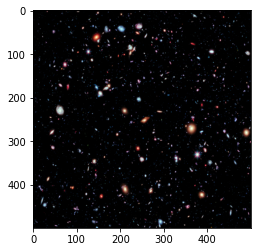

In [16]:
# the width/height of the image in pixels
pixels = 500
# the width/height of the image in arcseconds
image_size = 50 * u.arcsec

# a scale parameter used for conversion between pixels and arcseconds
pixel_size = image_size / pixels

# choose what image we want to lens, put it in a nice format, and display
# if you want to use no color, change the argument in convert() to 'L'
# if you do want color, change the argument in convert() to 'RGB'
im = Image.open('./test_images/test_image_19.jpg').convert('RGB')
im = im.resize((pixels,pixels))
test_image = np.array(im)
plt.imshow(test_image)
im.close()

In [17]:
x = 5     # lens x location in arcseconds
y = 0     # lens y location in arcseconds
minimum_normalized_angle = 0.0

"""
We are sticking with the default physical properties of the lens described
in section I, but different ones can be used by assigning values here. But
the default ones are kept in the constructor's default parameters; we do
not need to assign them now.
"""
lens = Lens(source_image=test_image,
            lens_x=x, lens_y=y,
            pixel_size=pixel_size,
            min_normalized_angle=minimum_normalized_angle)
"""
verbosity can be 0 or 1, 1 will print ten lines as the image is lensed,
to say where we are in the process. Values greater than 1 will be
ignored, but had use in older versions for extensive debug printing
"""
lens.deflect(method=2, verbosity=0)

"""Uncomment these lines if you want to save the numpy array for the result""";
# now = datetime.now()
# dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
# np.save("./test_results/"+dt_string+".npy", test_lens.result)

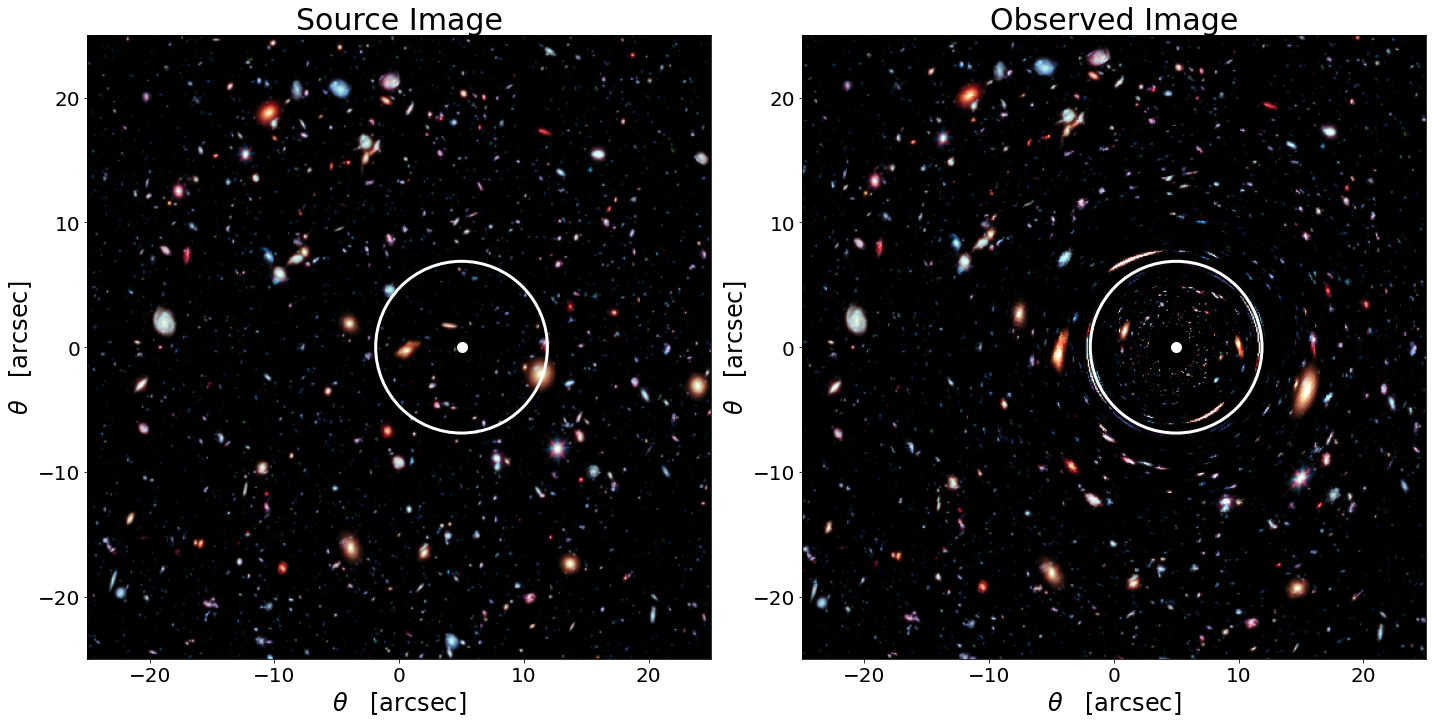

In [18]:
# log scale just gets ignored when working with color images
fig = lens.draw(do_circle=True, do_log_scale=False)

"""Uncomment these lines if you want to save the image for the result""";
# now = datetime.now()
# dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
# plt.savefig("./test_results/" + dt_string + ".png")